# Human Responses

- remove 'your name'
- tokenize
- cross validation on clustering?
- using longest responses?

In [29]:
import pandas as pd
import numpy as np
import random

np.random.seed(0)
random.seed(0)

In [30]:
# We use min(8, 9) = 8 prompts, so both corpuses have the same number of prompts
n_prompts = 8
# We use the longest n_samples_per_prompt samples for each prompt, measured by number of words
n_samples_per_prompt = 100

In [31]:
index_0 = np.concatenate([["prompt_id", "text"], ["bert"] * 768])
index_1 = np.concatenate([["prompt_id", "text"], [i for i in range(768)]])
index = pd.MultiIndex.from_arrays([index_0, index_1])

## Reddit

In [32]:
pairs = []
for name in ["train", "test", "valid"]:
    with open("reddit/writingPrompts/" + name + ".wp_source") as f_prompts:
        prompts = f_prompts.readlines()
    with open("reddit/writingPrompts/" + name + ".wp_target") as f_responses:
        texts = f_responses.readlines()
    assert len(prompts) == len(texts)
    pairs.extend(list(zip(prompts, texts)))
df_reddit = pd.DataFrame(pairs, columns=["prompt", "text"])
df_reddit = df_reddit[~df_reddit["prompt"].str.contains("hitler", case=False)]
df_reddit = df_reddit.drop_duplicates(subset=["text"])
df_reddit = df_reddit[
    df_reddit["prompt"].isin(df_reddit["prompt"].value_counts().index[:n_prompts])
]
df_reddit["prompt_id"] = df_reddit["prompt"].astype("category").cat.codes

# Get the longest n_samples responses for each prompt
df_reddit["text_len"] = df_reddit["text"].apply(lambda x: len(str.split(x)))
df_reddit = (
    df_reddit.groupby("prompt_id")
    .apply(lambda x: x.nlargest(n_samples_per_prompt, "text_len"), include_groups=False)
    .reset_index(level=0, drop=False)
    .reset_index(drop=True)
)

# Break prompt into prompt and and prompt_tag
df_reddit["prompt_tag"] = (
    df_reddit["prompt"]
    .str.split(" \]", n=1)
    .str[0]
    .replace("\[", "", regex=True)
    .str.strip()
)
df_reddit["prompt"] = df_reddit["prompt"].str.split(" \]", n=1).str[1].str.strip()
df_reddit["prompt"] = "Prompt\n" + df_reddit["prompt"]
df_reddit["prompt_id"] = df_reddit["prompt"].astype("category").cat.codes

In [33]:
df_reddit_prompts = (
    df_reddit[["prompt_id", "prompt", "prompt_tag"]]
    .drop_duplicates()
    .sort_values("prompt_id")
    .reset_index(drop=True)
)


def modify_prompt(prompt):
    prompt = prompt.split("\n")[1]
    return "Write a response to the following creative writing prompt:\n" + prompt


df_reddit_prompts["prompt"] = df_reddit_prompts["prompt"].apply(modify_prompt)

df_reddit_prompts.to_csv("reddit_prompts.csv", index=False)

In [34]:
df_reddit = df_reddit[["prompt_id", "text"]]
df_reddit = df_reddit.sort_values("prompt_id").reset_index(drop=True)
df_reddit.to_csv("reddit_responses/human.csv", index=False)

```
WP: Writing Prompt
SP: Simple Prompt
EU: Established Universe
CW: Constrained Writing
TT: Theme Thursday
PM: Prompt Me
MP: Media Prompt
IP: Image Prompt
PI: Prompt Inspired
OT: Off Topic
* OT as an Advertisement!
RF: Reality Fiction
```

https://www.reddit.com/r/WritingPrompts/wiki/how_to_tag_prompts/

In [35]:
df_reddit_prompts

,prompt_id,prompt,prompt_tag
0,0,Write a response to the following creative wri...,WP
1,1,Write a response to the following creative wri...,WP
2,2,Write a response to the following creative wri...,WP
3,3,Write a response to the following creative wri...,WP
4,4,Write a response to the following creative wri...,CW
5,5,Write a response to the following creative wri...,WP
6,6,Write a response to the following creative wri...,WP
7,7,Write a response to the following creative wri...,WP


In [36]:
df_reddit

,prompt_id,text
0,0,`` We left them there to study ! '' Proclaimed...
1,0,“ I suggest we initiate protocol Zestraol ” <n...
2,0,Our War Council was surprised when these Human...
3,0,"`` Drax , the Slovians have taken E13-49e , 4t..."
4,0,"`` They 've taken Marin , sir . '' <newline> <..."
...,...,...
795,7,"I 'd see her walking down the hall , her hair ..."
796,7,Wait . <newline> <newline> Doubt was settling ...
797,7,It started as a chauvinistic affair meant to m...
798,7,Izzard stalked through the once slicked stone ...


In [37]:
print("Number of words in the responses:")
df_reddit["text"].apply(lambda x: len(x.split())).describe()

Number of words in the responses:


count     800.00000
mean      695.49625
std       514.91980
min       121.00000
25%       290.00000
50%       520.00000
75%       932.25000
max      2594.00000
Name: text, dtype: float64

## Hewlett

https://www.kaggle.com/competitions/asap-aes/code

In [38]:
import os

hewlett_prompts_dir = "hewlett/prompts"

prompts = []
for file in os.listdir(hewlett_prompts_dir):
    with open(hewlett_prompts_dir + "/" + file) as f:
        prompt = f.read()
    prompts.append((int(file.split(".")[0]) - 1, prompt))

df_hewlett_prompts = pd.DataFrame(prompts, columns=["prompt_id", "prompt"])
df_hewlett_prompts["prompt_tag"] = df_hewlett_prompts["prompt"].str.contains(
    "Source Essay"
)
df_hewlett_prompts["prompt_tag"] = df_hewlett_prompts["prompt_tag"].replace(
    {True: "source dependent responses", False: "persuasive / narrative / expository"}
)
df_hewlett_prompts = df_hewlett_prompts.sort_values("prompt_id").reset_index(drop=True)
df_hewlett_prompts.to_csv("hewlett_prompts.csv", index=False)

In [39]:
hewlett_dir = "hewlett"

filenames = [
    "training_set_rel3.tsv",
    "valid_set.tsv",
    "test_set.tsv",
]

dfs = []
for filename in filenames:
    df = pd.read_csv(f"{hewlett_dir}/{filename}", sep="\t", encoding="ISO-8859-1")
    df = df[["essay_set", "essay"]]
    df.rename(columns={"essay_set": "prompt_id", "essay": "text"}, inplace=True)
    df["prompt_id"] = df["prompt_id"].astype(int).apply(lambda x: x - 1)
    dfs.append(df)

# Don't need to remove the responses of any prompts because there are 8 distinct prompts in this dataset
df_hewlett = pd.concat(dfs, ignore_index=True)

df_hewlett = df_hewlett[df_hewlett["text"] != ""]
df_hewlett = df_hewlett.dropna()
df_hewlett = df_hewlett.drop_duplicates()

# Get the longest n_samples responses for each prompt
df_hewlett["text_len"] = df_hewlett["text"].apply(lambda x: len(str.split(x)))
df_hewlett = (
    df_hewlett.groupby("prompt_id")
    .apply(lambda x: x.nlargest(n_samples_per_prompt, "text_len"), include_groups=False)
    .reset_index(level=0, drop=False)
    .reset_index(drop=True)
)
df_hewlett = df_hewlett[["prompt_id", "text"]]

df_hewlett.to_csv("hewlett_responses/human.csv", index=False)

In [40]:
df_hewlett_prompts

,prompt_id,prompt,prompt_tag
0,0,"Prompt\nMore and more people use computers, bu...",persuasive / narrative / expository
1,1,"Prompt\nCensorship in the Libraries\n""All of u...",persuasive / narrative / expository
2,2,Source Essay\nROUGH ROAD AHEAD: Do Not Exceed ...,source dependent responses
3,3,Source Essay\nWinter Hibiscus by Minfong Ho\nS...,source dependent responses
4,4,Source Essay\nNarciso Rodriguez\nfrom Home: Th...,source dependent responses
5,5,Source Essay\nThe Mooring Mast\nby Marcia Amid...,source dependent responses
6,6,Prompt\nWrite about patience. Being patient me...,persuasive / narrative / expository
7,7,Prompt\nWe all understand the benefits of laug...,persuasive / narrative / expository


In [41]:
df_hewlett

,prompt_id,text
0,0,My standing postion on this cause is that comp...
1,0,"@ORGANIZATION1, @CAPS1? Are you there?"" ""@CAPS..."
2,0,"Dear The @CAPS1 newspaper, @CAPS2 in front of ..."
3,0,Dear @CAPS1 Society: Computers are perhaps one...
4,0,"Dear @ORGANIZATION1, The creation of computers..."
...,...,...
795,7,"We couldn't control our selves, our eyes wate..."
796,7,It all started at the play ground @CAPS9 me ...
797,7,For my family laughter is important to us bec...
798,7,"Laughter, one of the greatest gifts in life. ..."


In [42]:
print("Number of words in the responses:")
df_hewlett["text"].apply(lambda x: len(x.split())).describe()

Number of words in the responses:


count     800.000000
mean      465.585000
std       246.627283
min       205.000000
25%       254.000000
50%       351.500000
75%       718.000000
max      1064.000000
Name: text, dtype: float64

# LLM response generation

## Aggregate generation

In [57]:
from tqdm import tqdm
import pandas as pd


def generate_responses(dataset_name, generate, model_name, temp=None):
    prompts_df = pd.read_csv(f"{dataset_name}_prompts.csv")
    prompt_ids = []
    responses = []

    progress_bar = tqdm(total=len(prompts_df) * n_samples_per_prompt)

    for prompt, prompt_id in zip(prompts_df["prompt"], prompts_df["prompt_id"]):
        for _ in range(n_samples_per_prompt):
            prompt_ids.append(prompt_id)
            if temp is not None:
                responses.append(generate(model_name, prompt, temp))
            else:
                responses.append(generate(model_name, prompt))
            progress_bar.update(1)

    progress_bar.close()

    df = pd.DataFrame({"prompt_id": prompt_ids, "text": responses})
    if temp != None:
        df.to_csv(f"{dataset_name}_responses/{model_name}_{temp}.csv", index=False)
    else:
        df.to_csv(f"{dataset_name}_responses/{model_name}.csv", index=False)

## Gemini (1.0 and 1.5)

In [17]:
import time
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold


with open("API_KEY_GOOGLE.txt", "r") as f:
    API_KEY_GOOGLE = f.read()

genai.configure(api_key=API_KEY_GOOGLE)

gemini_1 = "gemini-1.0-pro"
gemini_15 = "gemini-1.5-pro-latest"


def generate_gemini(model_name, prompt):
    safety_settings = {
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    }

    model = genai.GenerativeModel(
        f"models/{model_name}", safety_settings=safety_settings
    )

    while True:
        start = time.time()
        response = model.generate_content(prompt)
        # Gemini sometimes returns an empty response due to "SAFETY", so try again
        if not response.parts:
            print(response.candidates)
            continue
        # Gemini has a rate limit of 15 requests per minute for 1.0 and 2 requests per minute for 1.5
        wait_time = 30 if "1.5" in model_name else 4
        time.sleep(max(0, wait_time + 1 - (time.time() - start)))
        return " ".join([part.text for part in response.parts])

/home2/hstropkay/llm-style/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
generate_responses("reddit", generate_gemini, gemini_1)
generate_responses("reddit", generate_gemini, gemini_15)

generate_responses("hewlett", generate_gemini, gemini_1)
generate_responses("hewlett", generate_gemini, gemini_15)

## GPT (3.5, 4.0, and 3.5 with temp = [0.0, 0.1,...,1.5])

In [18]:
from openai import OpenAI

with open("API_KEY_OPENAI.txt", "r") as f:
    API_KEY_OPENAI = f.read()

model_name_35 = "gpt-3.5-turbo-0125"
model_name_4 = "gpt-4-turbo-2024-04-09"


def generate_gpt(model_name, prompt, temp=None):
    client = OpenAI(api_key=API_KEY_OPENAI)

    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
    ]
    response = None
    if temp != None:
        response = client.chat.completions.create(
            model=model_name,
            messages=messages,
            temperature=temp,
        )
    else:
        response = client.chat.completions.create(
            model=model_name,
            messages=messages,
        )
    return response.choices[0].message.content

In [ ]:
generate_responses("reddit", generate_gpt, model_name_35)
generate_responses("reddit", generate_gpt, model_name_4)
for temp in [i / 10 for i in range(16)]:
    generate_responses("reddit", generate_gpt, model_name_35, temp)

generate_responses("hewlett", generate_gpt, model_name_35)
generate_responses("hewlett", generate_gpt, model_name_4)
for temp in [i / 10 for i in range(16)]:
    generate_responses("hewlett", generate_gpt, model_name_35, temp)

## Claude (Sonnet and Opus)

In [19]:
import anthropic

with open("API_KEY_ANTHROPIC.txt", "r") as f:
    API_KEY_ANTHROPIC = f.read()


model_name_sonnet = "claude-3-sonnet-20240229"
model_name_opus = "claude-3-opus-20240229"


def generate_claude(model_name, prompt):
    client = anthropic.Anthropic(api_key=API_KEY_ANTHROPIC)

    message = client.messages.create(
        model=model_name,
        max_tokens=4096,
        messages=[{"role": "user", "content": prompt}],
    )

    return message.content[0].text

In [ ]:
generate_responses("reddit", generate_claude, model_name_sonnet)
generate_responses("reddit", generate_claude, model_name_opus)

generate_responses("hewlett", generate_claude, model_name_sonnet)
generate_responses("hewlett", generate_claude, model_name_opus)

## Response lengths

# Function words

In [9]:
from nltk.tokenize import word_tokenize
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler


with open("function_words/oshea.txt") as f:
    lines = f.readlines()
    function_words = [line.split()[0] for line in lines]


def delta(df, function_words, variant):
    # Get word counts of all words, using the NLTK tokenizer for all responses
    vectorizer = TfidfVectorizer(
        use_idf=False, norm=None, tokenizer=word_tokenize, token_pattern=None
    )
    word_counts = vectorizer.fit_transform(df["text"]).toarray()

    # Convert to relative frequencies for each document
    relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)

    # Keep the relative frquencies for only the function words
    function_word_indices = []
    oov = []
    for word in function_words:
        if word in vectorizer.vocabulary_:
            function_word_indices.append(vectorizer.vocabulary_[word])
        else:
            oov.append(word)

    fw_relative_freqs = relative_freqs[:, function_word_indices]
    print(f"{len(oov)} words not in corpus: {oov}")

    # Convert to z-scores
    scaler = StandardScaler()
    z_scores = scaler.fit_transform(fw_relative_freqs)

    # Optionally return the z-scores
    if variant == "z_scores":
        return z_scores

    # Return the distance matrix
    if variant == "burrows":
        return cdist(z_scores, z_scores, metric="cityblock")
    if variant == "cosine":
        return cdist(z_scores, z_scores, metric="cosine")

    raise ValueError(f"Unknown variant: {variant}")

In [10]:
import pandas as pd
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import make_blobs
from scipy.stats import distributions
from sklearn.metrics import make_scorer


HUMAN = "human"

GEMINI_1 = "gemini-1.0-pro"
GEMINI_15 = "gemini-1.5-pro-latest"

CLAUDE_SONNET = "claude-3-sonnet-20240229"
CLAUDE_OPUS = "claude-3-opus-20240229"

GPT_35 = "gpt-3.5-turbo-0125"
GPT_4 = "gpt-4-turbo-2024-04-09"


authors = [
    HUMAN,
    GEMINI_1,
    GEMINI_15,
    CLAUDE_SONNET,
    CLAUDE_OPUS,
    GPT_35,
    # , GPT_4]
]

# Classification

In [29]:
import random

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


def classify(df, function_words):
    # Train-test split
    prompt_ids = df["prompt_id"].unique().tolist()
    test_prompts = random.sample(prompt_ids, 2)
    df_test = df[df["prompt_id"].isin(test_prompts)].reset_index(drop=True)
    df_train = df[~df["prompt_id"].isin(test_prompts)].reset_index(drop=True)

    # Get word counts of all words, using the NLTK tokenizer for all responses
    vectorizer = TfidfVectorizer(
        use_idf=False, norm=None, tokenizer=word_tokenize, token_pattern=None
    )
    word_counts_train = vectorizer.fit_transform(df_train["text"]).toarray()
    word_counts_test = vectorizer.transform(df_test["text"]).toarray()

    # Convert to relative frequencies for each document
    rel_freqs_train = word_counts_train / word_counts_train.sum(axis=1, keepdims=True)
    rel_freqs_test = word_counts_test / word_counts_test.sum(axis=1, keepdims=True)

    # Keep the relative frequencies for only the function words
    function_word_indices = []
    for word in function_words:
        if word in vectorizer.vocabulary_:
            function_word_indices.append(vectorizer.vocabulary_[word])

    fw_relative_freqs_train = rel_freqs_train[:, function_word_indices]
    fw_relative_freqs_test = rel_freqs_test[:, function_word_indices]

    # Convert to z-scores
    scaler = StandardScaler()
    z_scores_train = scaler.fit_transform(fw_relative_freqs_train)
    z_scores_test = scaler.transform(fw_relative_freqs_test)

    # Set up cross-validation
    train_indices_by_prompt = (
        df_train.groupby("prompt_id")
        .apply(lambda x: x.index, include_groups=False)
        .tolist()
    )
    cv_iterable = []
    for _ in range(3):
        train_indices_by_prompt = (
            train_indices_by_prompt[2:] + train_indices_by_prompt[:2]
        )
        val_indices = np.concatenate(train_indices_by_prompt[:2])
        train_indices = np.concatenate(train_indices_by_prompt[2:])
        cv_iterable.append((train_indices, val_indices))

    # Verify that no prompt in each validation set is the corresponding train set
    for train_indices, val_indices in cv_iterable:
        assert (
            len(
                set(df_train.loc[train_indices, "prompt_id"].unique()).intersection(
                    set(df_train.loc[val_indices, "prompt_id"].unique())
                )
            )
            == 0
        )

    # Train the model using grid search
    model = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid={
            "C": [0.001, 0.003, 0.01, 0.03, 0.1],
            "solver": ["liblinear", "lbfgs"],
        },
        cv=cv_iterable,
        n_jobs=-1,
        refit=True,
    )

    model.fit(z_scores_train, df_train["author"])
    y_pred = model.predict(z_scores_test)

    return df_test["author"], y_pred

In [34]:
from sklearn.metrics import classification_report


for dataset in ["reddit", "hewlett"]:
    dfs = []
    for author in authors:
        df = pd.read_csv(f"{dataset}_responses/{author}.csv")
        df["author"] = author
        dfs.append(df)
    df = pd.concat([df for df in dfs], ignore_index=True)

    y_true, y_pred = classify(df)
    report = classification_report(y_true, y_pred, zero_division=0)
    print(f"Dataset: {dataset}")
    print(report)

Dataset: reddit
                          precision    recall  f1-score   support

  claude-3-opus-20240229       0.33      0.26      0.29       200
claude-3-sonnet-20240229       0.18      0.09      0.12       200
          gemini-1.0-pro       0.93      0.28      0.42       200
   gemini-1.5-pro-latest       0.82      0.59      0.69       200
      gpt-3.5-turbo-0125       0.94      0.09      0.16       200
                   human       0.28      0.99      0.43       200

                accuracy                           0.38      1200
               macro avg       0.58      0.38      0.35      1200
            weighted avg       0.58      0.38      0.35      1200

Dataset: hewlett
                          precision    recall  f1-score   support

  claude-3-opus-20240229       0.39      0.18      0.25       200
claude-3-sonnet-20240229       0.62      0.23      0.33       200
          gemini-1.0-pro       0.50      0.29      0.37       200
   gemini-1.5-pro-latest       0.84    

50 words not in corpus: ['yourselves', 'himself', 'noone', 'hers', 'wherever', 'whyever', 'therein', 'thereupon', 'thereafter', 'whereafter', 'whereby', 'wherein', 'whereupon', 'namely', 'afterwards', 'meanwhile', 'anyhow', 'eg', 'ie', 're', 'amongst', 'amoungst', 'beside', 'thence', 'thru', 'cannot', 'ought', 'dare', 'beforehand', 'elsewhere', 'formerly', 'hereafter', 'hereabouts', 'hereinafter', 'heretofore', 'herewith', 'hereunder', 'hereby', 'herein', 'hereupon', 'latterly', 'nowhere', 'somehow', 'sometime', 'somewhat', 'thereabouts', 'thereof', 'thereon', 'whither', 'whence']


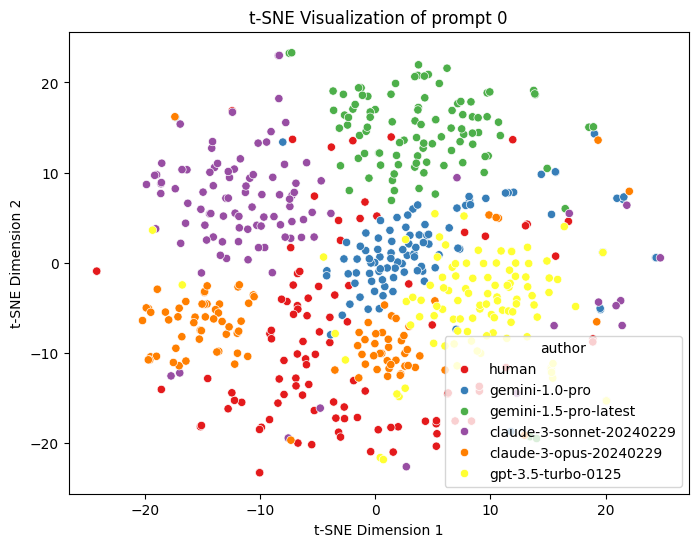

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

df_prompt_0 = df[df["prompt_id"] == 0]
z_scores_prompt_0 = delta(df_prompt_0, function_words, variant="z_scores")

tsne = TSNE(random_state=42)
X_tsne = tsne.fit_transform(z_scores_prompt_0)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=df_prompt_0["author"],
    palette="Set1",
)
plt.title("t-SNE Visualization of prompt 0")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

29 words not in corpus: ['whyever', 'therein', 'thereupon', 'whereafter', 'whereby', 'wherein', 'whereupon', 'namely', 'anyhow', 'eg', 'ie', 'amoungst', 'thence', 'thru', 'cannot', 'hereafter', 'hereabouts', 'hereinafter', 'heretofore', 'herewith', 'hereunder', 'hereby', 'herein', 'hereupon', 'latterly', 'thereabouts', 'thereon', 'whither', 'whence']


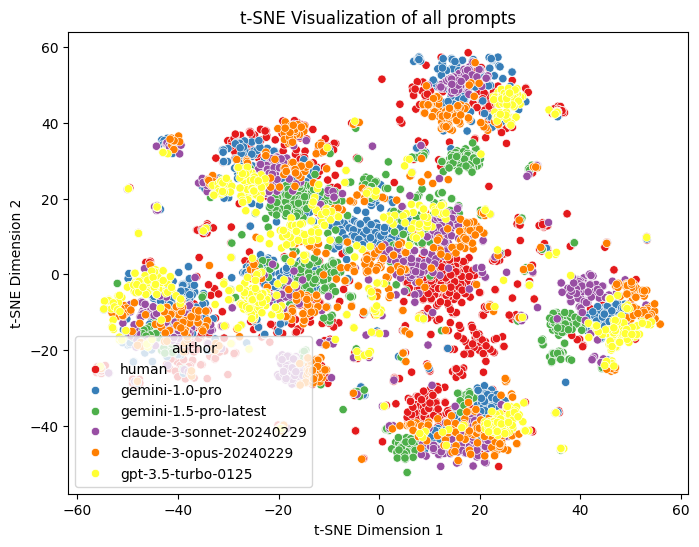

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

z_scores = delta(df, function_words, variant="z_scores")

tsne = TSNE(random_state=42)
X_tsne = tsne.fit_transform(z_scores)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=df["author"],
    palette="Set1",
)
plt.title("t-SNE Visualization of all prompts")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()